In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression, RidgeCV, RidgeClassifier, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score, log_loss, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

''' Suppress all warnings '''
warnings.filterwarnings("ignore")
from scipy.stats import jarque_bera, kstest

In [4]:
# df_reject = pd.read_csv('01_rejected_2007_to_2018Q4.csv')
df_accept = pd.read_csv('01_accepted_2007_to_2018Q4.csv', low_memory=False)
df_accept.shape

(2260701, 151)

In [6]:
''' Selecting Training Data '''
df_accept_subst = df_accept[df_accept['issue_d'].isin(['Aug-2014','Sep-2014','Oct-2014','Nov-2014','Dec-2014'])]
df_accept_subst.shape

(103564, 151)

In [8]:
''' Distribution of loan_status column by it's values '''
df_accept_subst[['loan_status']].value_counts()

loan_status       
Fully Paid            77616
Charged Off           18470
Current                7146
Late (31-120 days)      179
In Grace Period         111
Late (16-30 days)        41
Default                   1
Name: count, dtype: int64

### Target Variable

In [10]:
# Creating Bad Flag
df_accept_subst['Bad_Flag'] = [1 if df_accept_subst['loan_status'].iloc[i] == 'Charged Off' else 0 for i in range(len(df_accept_subst))]

In [12]:
df_accept_subst['Bad_Flag'].value_counts()

Bad_Flag
0    85094
1    18470
Name: count, dtype: int64

### Categorical and Date Variables

In [14]:
''' Getting a sense of the Categorical and Date variables, that are either need to be excluded or converted to dummy variables to be
    used as numerical variables in the analysis'''
groups = df_accept_subst.select_dtypes(exclude="number").columns
for i in groups:
    print(f'For {df_accept_subst[i].value_counts()}\n')

For id
36805548    1
28653181    1
28563299    1
28623107    1
28693247    1
           ..
33240647    1
32510064    1
33240616    1
32520252    1
20479455    1
Name: count, Length: 103564, dtype: int64

For term
36 months    70674
60 months    32890
Name: count, dtype: int64

For grade
C    28595
B    26392
A    18253
D    17768
E     8840
F     2883
G      833
Name: count, dtype: int64

For sub_grade
C1    6224
C2    6090
C3    5770
B4    5759
C4    5727
B3    5543
B5    5514
A5    5138
B2    4928
C5    4784
B1    4648
D1    4501
A4    4271
D2    3819
D3    3449
D4    3387
A2    2967
A3    2964
A1    2913
D5    2612
E1    2374
E2    2093
E3    1693
E4    1469
E5    1211
F1     877
F2     655
F3     587
F4     439
F5     325
G1     275
G2     208
G3     134
G4     113
G5     103
Name: count, dtype: int64

For emp_title
Teacher                             1953
Manager                             1718
Owner                                829
Registered Nurse                     812
RN  

### Dropping Variables

In [16]:
#################### Dropping the following variables. These variables donot have significance in predicting the Target #####################
dropped_col = ['loan_status','id','annual_inc','url','title','zip_code','addr_state','issue_d','next_pymnt_d','sub_grade','emp_title',\
               'earliest_cr_line', 'last_credit_pull_d', 'last_pymnt_d', 'hardship_start_date','hardship_end_date','payment_plan_start_date',\
               'debt_settlement_flag_date','settlement_date','desc']

df_accept_subst.drop(dropped_col,axis = 1, inplace = True)
drp_1 = df_accept_subst.shape # (103564, 132)

### Missing Analyzer

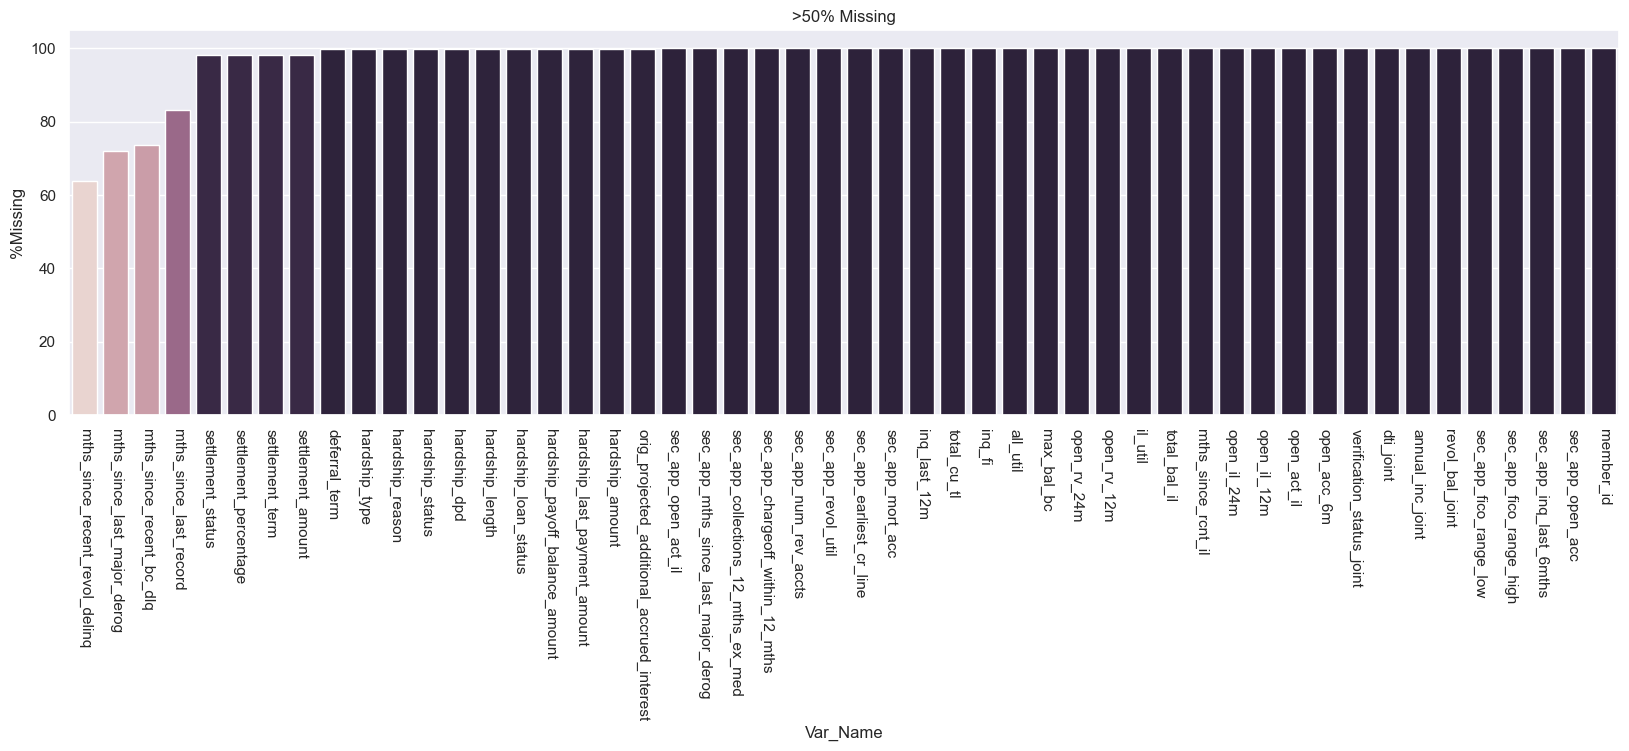

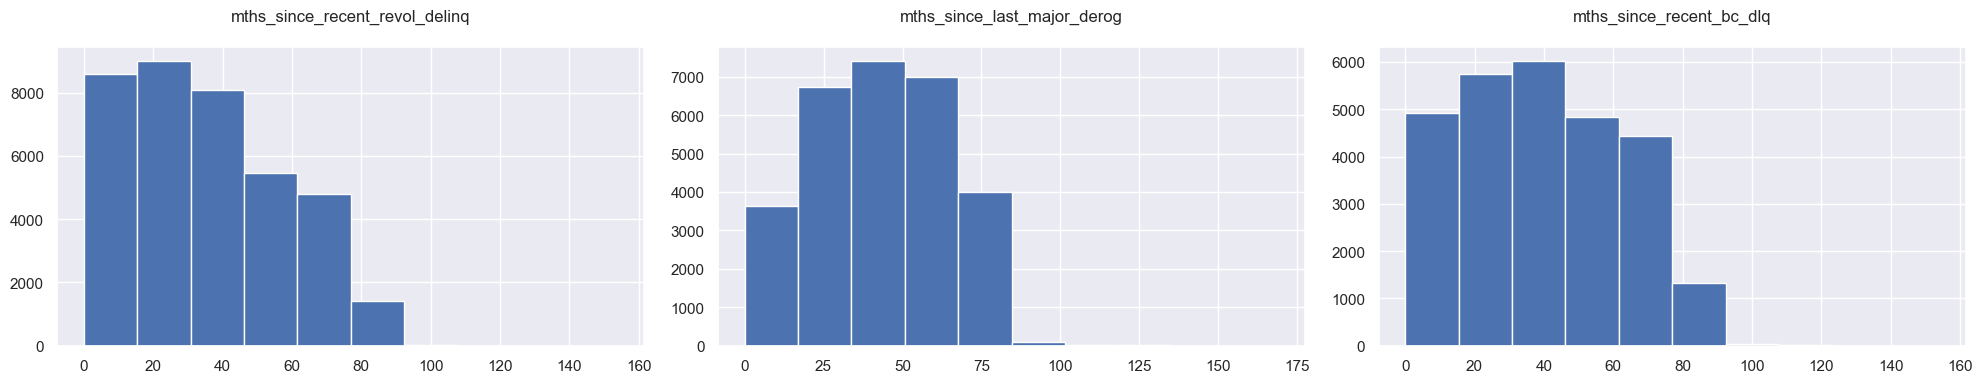

Text(0.5, 1.0, '1% - 50% Missing')

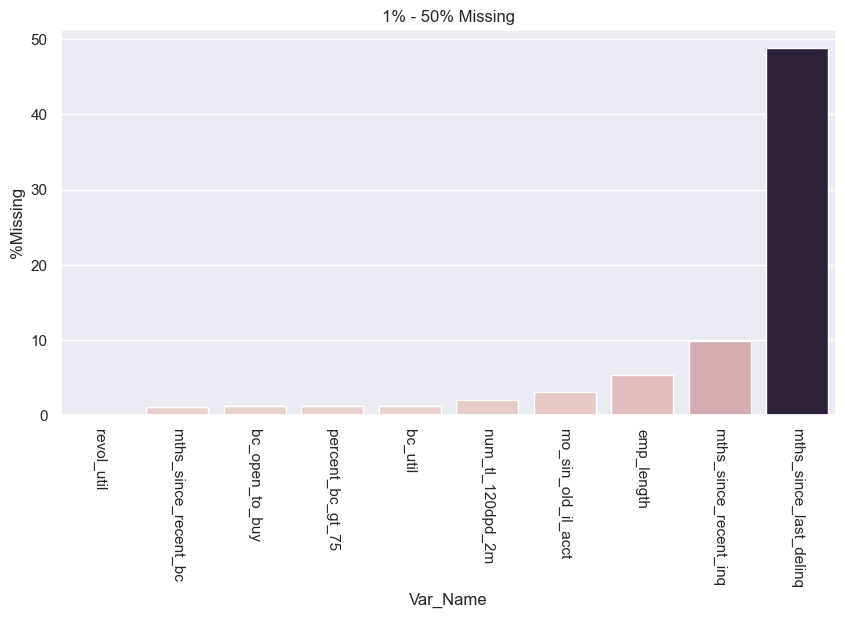

In [18]:
# Missing Analyzer - This step tells us the amount of missing values per variable
lst = []
for i in df_accept_subst.columns:
    lst.append((i,df_accept_subst[i].isnull().sum()/len(df_accept_subst)*100))

''' Plotting variables with Missing % > 50 ''' 
df = pd.DataFrame(lst, columns = ['Var_Name','%Missing']).sort_values(by = '%Missing')
sns.set_theme(rc={'figure.figsize':(20,5)})
ax = sns.barplot(df.loc[df['%Missing']>50], x='Var_Name', y='%Missing', hue = "%Missing", legend = False)
ax.tick_params(axis='x', labelrotation=-90)
ax.set_title('>50% Missing')

# Selecting only those columns that have more than 50% missing to be either imputed or dropped
# df.loc[df['%Missing']>50].to_excel('GT50perc_Missing.xlsx')

'''The following columns have upto 80% missing values. They also make business sense especially when they are deregatory variables.
Hence decided to keep them in the analysis by imputing their missing values. Analyzing their distribution for selecting a suitable 
imputation method'''
groups = df['Var_Name'].loc[(df['%Missing']>=50) & (df['%Missing']<80) & (~df['Var_Name'].isin(dropped_col))].tolist()
fig, axes = plt.subplots(nrows=1, ncols=len(groups), figsize=(20, 4))

for ax, col in zip(axes, groups):
    subset = df_accept_subst[col]
    df_accept_subst[col].hist(ax=ax)
    ax.set_title(f'{col}\n')

plt.tight_layout()
plt.show()

# Obtaining the mean,median,min,max etc. for the variables headed for imputation
df_accept_subst[groups].describe()

''' Plotting variables with Missing % <= 50 '''
sns.set_theme(rc={'figure.figsize':(10,5)})
ax1 = sns.barplot(df.loc[(df['%Missing']>0) & (df['%Missing']<=50)], x='Var_Name', y='%Missing', hue = "%Missing", legend = False)
ax1.tick_params(axis='x', labelrotation=-90)
ax1.set_title('1% - 50% Missing')

### Missing Imputation

In [20]:
################################################## Dropping varibales with Missing % >= 80 ##################################################
for i in df_accept_subst.columns:
    if round(df_accept_subst[i].isnull().sum()/len(df_accept_subst)*100,4) >= 80:
        df_accept_subst.drop(i, axis=1, inplace = True)
drp_2 = df_accept_subst.shape

########################################## Imputing variables where Missing % >= 50 and <80 with 0 ##########################################
groups = df['Var_Name'].loc[(df['%Missing']>=50) & (df['%Missing']<80) & (~df['Var_Name'].isin(dropped_col))].tolist()
df1 = df_accept_subst.copy()
df1 = df1[groups + ['Bad_Flag']]
for i in groups:
    df1[f'{i}_bin'] = (pd.qcut(df1[i], 4)).astype(str)    
    df_temp = df1.groupby(f'{i}_bin').sum()['Bad_Flag']/df1[f'{i}_bin'].value_counts(dropna = False)
    df_temp = df_temp.to_frame().reset_index()
    df_temp.rename(columns={0:'Bad_Rate'}, inplace=True)
    # print(df_temp)

    ''' Since these are delinquency columns, the business might have NULL values for customers who are not delinquent '''
    df_accept_subst[i].loc[df_accept_subst[i].isnull()] = 99999
    del df_temp
del df1
drp_3 = df_accept_subst.shape

############################################# Imputing variables where Missing % > 0 and <50 ################################################
''' Binning the columns to be imputed. Imputing with the median value of the non-null bucket, where:
    Bad Rate of Non-Null bucket (is almost) = Bad Rate of Null bucket '''
df1 = df_accept_subst.copy()
groups = df['Var_Name'].loc[(df['%Missing']>0) & (df['%Missing']<50) & (~df['Var_Name'].isin(dropped_col))].tolist()
groups = (df1[groups].select_dtypes(include='number')).columns.tolist()
df1 = df1[groups + ['Bad_Flag']]

for i in groups:
    df1[f'{i}_bin'] = (pd.qcut(df1[i], 4, duplicates='drop')).astype(str)
    df_med = df1.groupby(f"{i}_bin")[i].apply(np.median)
    df_med = df_med.to_frame().reset_index()
    df_med.rename(columns={i: f"{i}_median"}, inplace=True)
    df1 = pd.merge(df1, df_med, on=f'{i}_bin', how = 'inner')
    
    df_temp = df1.groupby(f'{i}_bin').sum()['Bad_Flag']/df1[f'{i}_bin'].value_counts(dropna = False)
    df_temp = df_temp.to_frame().reset_index()
    df_temp.rename(columns={0:'Bad_Rate'}, inplace=True)
    # print(df_temp)
    
    mn = 1000000
    for j in range(len(df_temp)):
        if df_temp[f'{i}_bin'][j] != 'nan':
            val = abs(df_temp['Bad_Rate'][j] - df_temp['Bad_Rate'].loc[df_temp[f'{i}_bin']=='nan'].values[0])
            if val < mn:
                mn = val
                intrvl = df_temp[f'{i}_bin'][j]
    df_accept_subst[i].loc[df_accept_subst[i].isnull()] = df1[f'{i}_median'].loc[df1[f'{i}_bin']==intrvl].unique()[0]
    del df_med, df_temp
del df1
drp_4 = df_accept_subst.shape

In [28]:
# drp_1 # (103564, 132)
# drp_2 # (103564, 85)
# drp_3 # (103564, 85)
# drp_4 # (103564, 85)

(103564, 85)

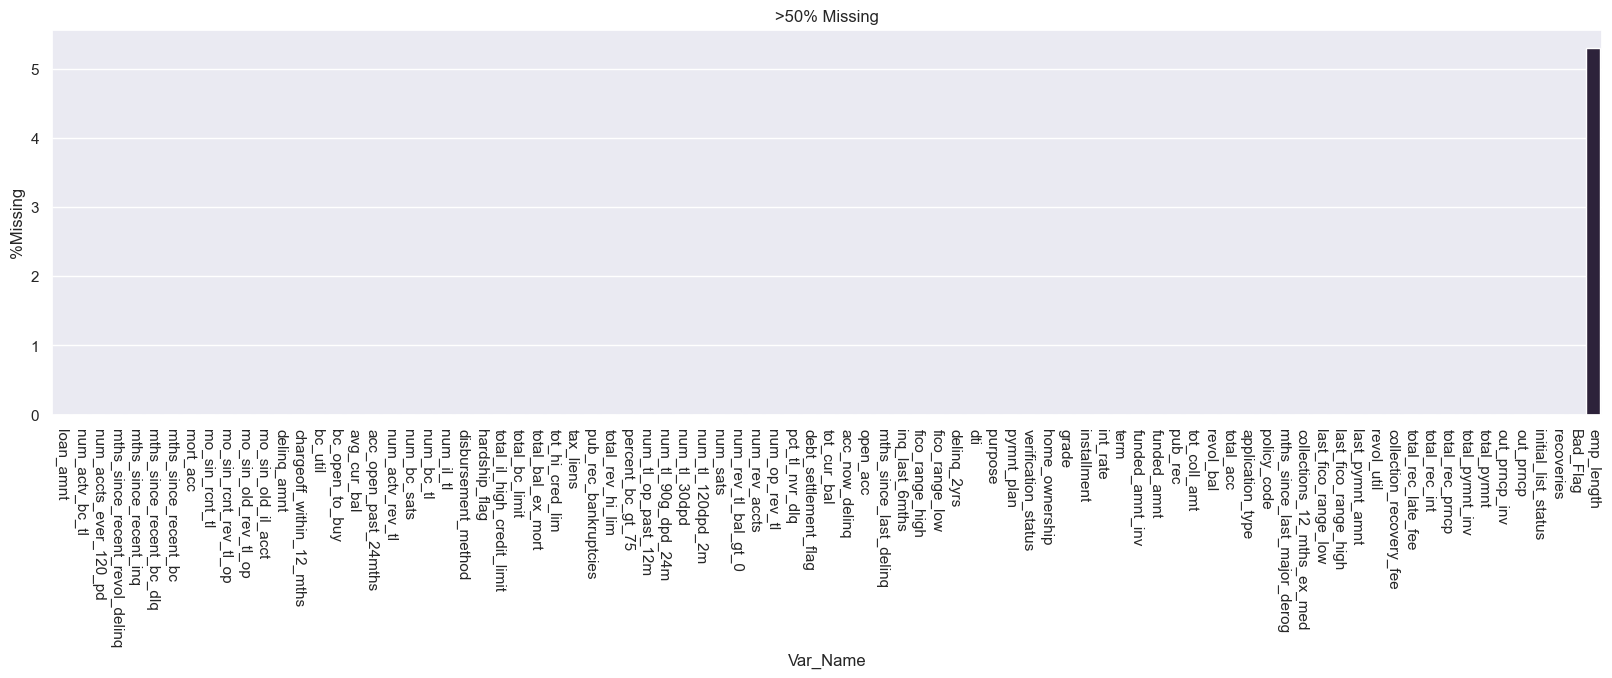

In [30]:
''' Post Missing Imputation '''
lst = []
for i in df_accept_subst.columns:
    lst.append((i,round(df_accept_subst[i].isnull().sum()/len(df_accept_subst)*100,1)))

''' Plotting variables with Missing % > 0 ''' 
df_trial = pd.DataFrame(lst, columns = ['Var_Name','%Missing']).sort_values(by = '%Missing')
sns.set_theme(rc={'figure.figsize':(20,5)})
ax = sns.barplot(df_trial.loc[df['%Missing']>=0], x='Var_Name', y='%Missing', hue = "%Missing", legend = False)
ax.tick_params(axis='x', labelrotation=-90)
ax.set_title('>50% Missing')
del df_trial

### Outlier Treatment

In [32]:
df1 = df_accept_subst.copy()
groups = (df1.select_dtypes(include='number')).columns.tolist()
for i in groups:
    # Calculate quantiles
    lower_limit = df1[i].quantile(0.05)
    upper_limit = df1[i].quantile(0.95)

    # Cap the outliers
    df1[i] = np.where(df1[i] < lower_limit, lower_limit, df1[i])
    df1[i] = np.where(df1[i] > upper_limit, upper_limit, df1[i])
df1.shape # (103564, 85)

(103564, 85)

### Defaulter Distribution by Categorical Variables

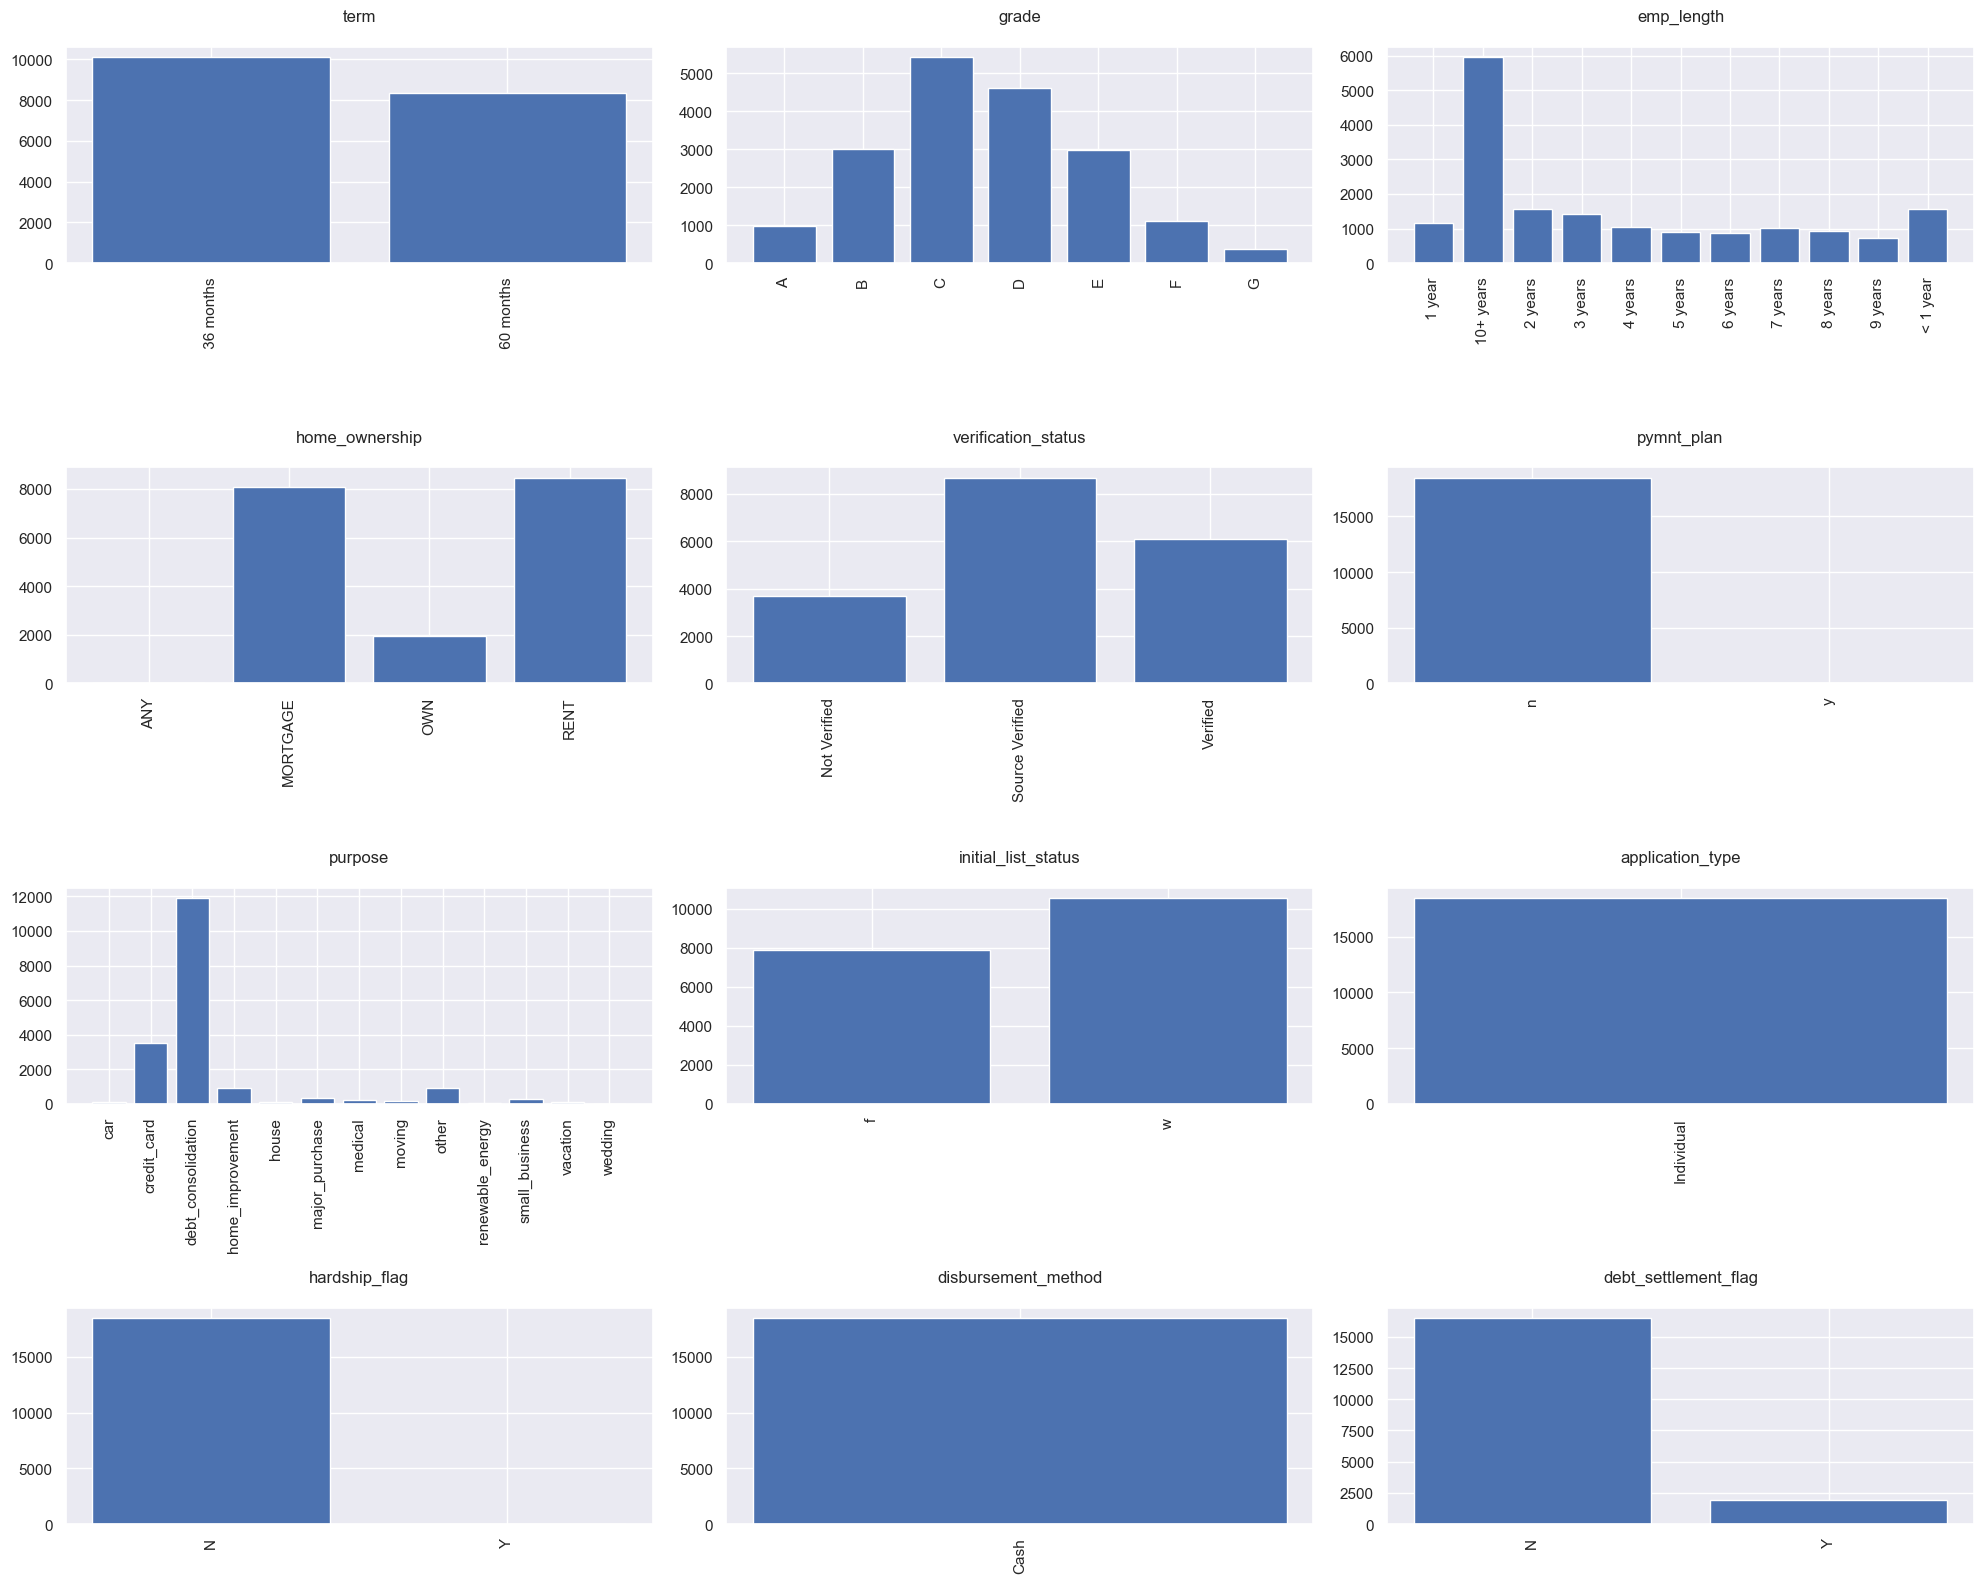

In [34]:
''' Looking at distrbution of defaulters by categorical variables. 
    - Helps in dismissing those that are counter-intuitive 
    - One-Hot encoding of the rest '''

groups = df1.select_dtypes(exclude="number").columns

ncols = 3 
nrows = (len(groups) + ncols - 1) // ncols

# Create a figure with the specified rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))

# Flatten axes array if it has more than 1 row for easier indexing
axes = axes.flatten() if nrows > 1 else [axes]

# Plot each category in a separate subplot
for ax, col in zip(axes, groups):
    df_temp = pd.DataFrame(df1.groupby([col]).sum()['Bad_Flag']).reset_index()
    ax.bar(df_temp[col], df_temp['Bad_Flag'])
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(f'{col}\n')

plt.tight_layout()
plt.show()

- Looking at the above plots, deciding to keep the following variables since they follow intuition:
   - home_ownership
   - verification_status
   - pymnt_plan
   - purpose
   - debt_settlement_flag

### One-Hot Encoding of the chosen Categorical Variables

In [36]:
# Applying one-hot encoding
# data_encoded = pd.get_dummies(df1, columns=['term','pymnt_plan','purpose','application_type','disbursement_method','debt_settlement_flag'], dtype='int')
data_encoded = pd.get_dummies(df1, columns=['home_ownership','verification_status','pymnt_plan','purpose','debt_settlement_flag'], dtype='int')
data_encoded.shape

(103564, 104)

In [38]:
dropped_col = data_encoded.select_dtypes(exclude='number').columns.tolist()
data_encoded.drop(dropped_col,axis = 1, inplace = True)
data_encoded.shape

(103564, 97)

### Quick and Dirty Model - KS & GINI Stat for Variable Selection

In [40]:
# Fit the model
lst = []
groups = (data_encoded.select_dtypes(include='number')).columns.tolist()
for i in groups:
    if i != 'Bad_Flag':
        model = LogisticRegression()
        model.fit(pd.DataFrame(data_encoded[i]),pd.DataFrame(data_encoded['Bad_Flag']))

        # Predict probabilities
        y_pred_proba = model.predict_proba(pd.DataFrame(data_encoded[i]))[:, 1]
        def calculate_ks(y_true, y_pred_proba):
            fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
            ks_statistic = max(tpr - fpr)
            return ks_statistic 
        ks_statistic = calculate_ks(data_encoded['Bad_Flag'], y_pred_proba)
        auc = roc_auc_score(data_encoded['Bad_Flag'], y_pred_proba)
        gini = 2 * auc - 1
        lst.append((i,ks_statistic,gini))

df_ks = pd.DataFrame(lst, columns = ['Var_Name','ks','gini']).sort_values(by = ['ks','gini'], ascending = False)
df_ks.to_excel('ks_numeric_vars.xlsx', index = False)
del df_ks

### Correlation Analysis

In [42]:
# Obtain Correlation
lst = []
groups = data_encoded.columns.tolist()
for i in groups:
    lst.append((i, pd.DataFrame(data_encoded[i]).corrwith(data_encoded["Bad_Flag"])[0], abs(pd.DataFrame(data_encoded[i]).corrwith(data_encoded["Bad_Flag"]))[0]))
df2 = pd.DataFrame(lst, columns = ['Var_Name','Correlation', 'Abs_Correlation']).sort_values(by = 'Abs_Correlation', ascending = False)
df2.to_excel('Pearson_Corr.xlsx')
del df2

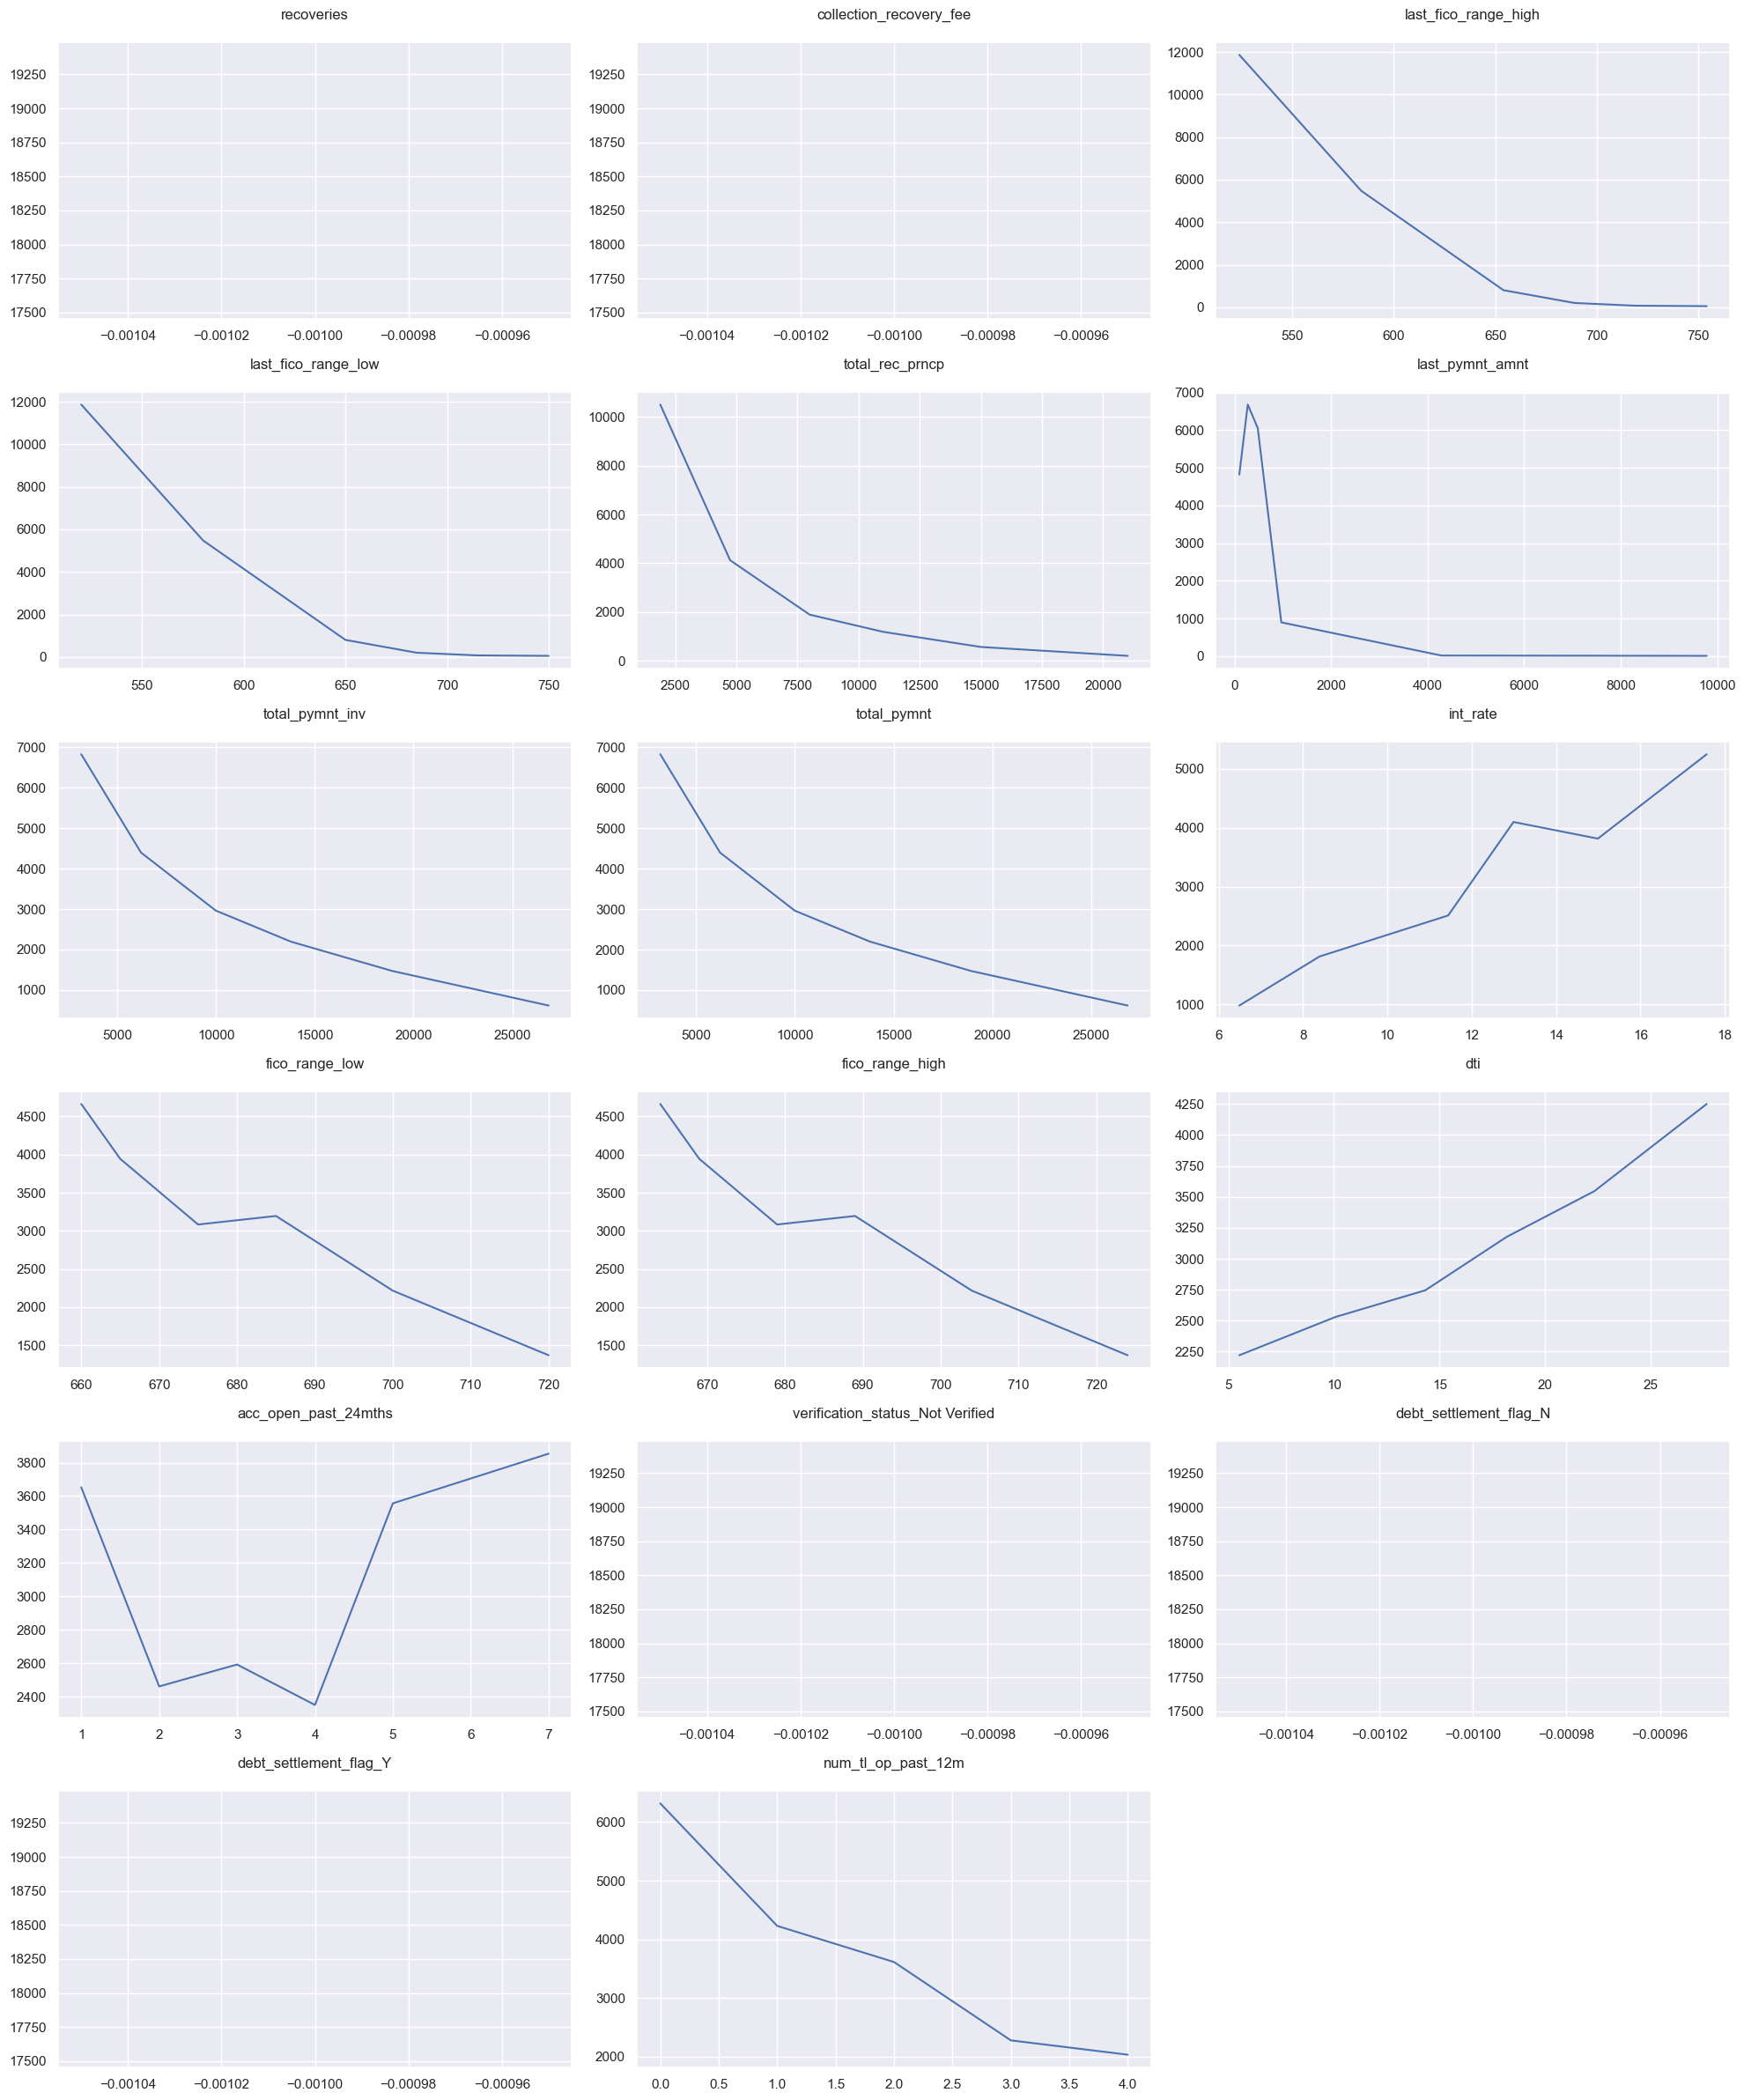

In [44]:
# Variable Selection after going through KS, GINI and Correlation spreadsheets
'''
recoveries
collection_recovery_fee
last_fico_range_high
last_fico_range_low
total_rec_prncp
last_pymnt_amnt
total_pymnt_inv
total_pymnt
int_rate
fico_range_low
fico_range_high
dti
acc_open_past_24mths
verification_status_Not Verified
debt_settlement_flag_N
debt_settlement_flag_Y
num_tl_op_past_12m
'''
groups = ['recoveries',	'collection_recovery_fee',	'last_fico_range_high',	'last_fico_range_low',	'total_rec_prncp',	'last_pymnt_amnt',\
          'total_pymnt_inv',	'total_pymnt',	'int_rate',	'fico_range_low',	'fico_range_high',	'dti',	'acc_open_past_24mths',	\
          'verification_status_Not Verified',	'debt_settlement_flag_N',	'debt_settlement_flag_Y',	'num_tl_op_past_12m']
ncols = 3 
nrows = (len(groups) + ncols - 1) // ncols

# Create a figure with the specified rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))

# Flatten axes array if it has more than 1 row for easier indexing
axes = axes.flatten() if nrows > 1 else [axes]

for ax, i in zip(axes, groups):
    var1 = pd.DataFrame((pd.qcut(data_encoded[i], 6, duplicates = 'drop'))).reset_index()
    var1[f'{i}_int'] = var1[i].apply(lambda x: x.left)
    
    var2 = pd.DataFrame(data_encoded['Bad_Flag']).reset_index()
    
    df_temp = pd.merge(var1,var2, on='index', how = 'inner')
    df_temp = pd.DataFrame(df_temp.groupby(f'{i}_int')['Bad_Flag'].sum()).reset_index()
    
    ax.plot(df_temp.iloc[:,0],df_temp.iloc[:,1])
    ax.set_title(f'{i}\n')
    del df_temp

# Hide any unused subplots if there are more subplots than groups
for i in range(len(groups), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Variables that makes sense to be included in the finally modeling process:
- last_fico_range_high : This follows intuition. Customers with lower fico scores have higher chances to default
- last_fico_range_low  : This follows intuition. Customers with lower fico scores have higher chances to default
- total_rec_prncp : Principal received to date. Lower the amount(could be unsecured products such as CC or IL) higher the chances to default
- last_pymnt_amnt : Last total payment amount received. This follows intuition. Higher payment amounts could indicate secured products.                          And secured products have lower chances to default
- total_pymnt_inv : Payments received to date as part of total amount funded by investors. This follows intuition since higher values of                         repayment indicates a stronger tendency to keep paying till the loan is fully repaid.
- total_pymnt : Payments received to date for total amount funded. Same explanation as above
- int_rate : Interest Rate on Loan. This follows intuition since higher interest rates are charged to customers who are risky. Now since                  they are risky, hence the defaulters. This could also be interpreted on the basis of product loaned. Unsecured products                      normally have higher interest rates vs secured products.
- fico_range_low : Follows intuition
- fico_range_high : Follows intuition
- dti : Monthly Debt(excluding mortgage and the requested LC loan) to monthly income. Higher DTI would indicate higher chances to default.           This follows intuition
- acc_open_past_24mths : Number of trades opened in past 24 months. More number of trades, indicates the customer could be credit hungry which in turn means higher chances to default. There is an exception with customers with trades open = 1
- num_tl_op_past_12m : Number of accounts opened in past 12 months. This is fairly intuitive. More accounts opened, indicate more engagement                        with the bank and more engagement could be considered as less likely to default
- recoveries : Single bin
- collection_recovery_fee : Single bin
- verification_status_Not Verified : Single bin
- debt_settlement_flag_N : Single bin
- debt_settlement_flag_Y : Single bin

### Correlation amongst Predictors and Check VIF -- Iterative Step

In [ ]:
############################################################## Iteration - 1 ##############################################################
groups = ['recoveries',	'collection_recovery_fee',	'last_fico_range_high',	'last_fico_range_low',	'total_rec_prncp',	'last_pymnt_amnt',\
          'total_pymnt_inv',	'total_pymnt',	'int_rate',	'fico_range_low',	'fico_range_high',	'dti',	'acc_open_past_24mths',	\
          'verification_status_Not Verified',	'debt_settlement_flag_N',	'debt_settlement_flag_Y',	'num_tl_op_past_12m']

# Calculate VIF for each predictor variable
df_temp = data_encoded[groups]
X = sm.add_constant(df_temp)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(f'{vif_data}\n')
data_encoded[groups].corr(method = 'pearson')

In [46]:
############################################################## Iteration - 2 ##############################################################
groups = ['recoveries', 'last_fico_range_high',	'total_rec_prncp', 'last_pymnt_amnt','int_rate', 'fico_range_high',\
          'dti', 'debt_settlement_flag_Y', 'num_tl_op_past_12m']
          
# Calculate VIF for each predictor variable
df_temp = data_encoded[groups]
X = sm.add_constant(df_temp)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(f'{vif_data}\n')
data_encoded[groups].corr(method = 'pearson')

                 Variable          VIF
0                   const  1023.208180
1              recoveries     1.476707
2    last_fico_range_high     1.551653
3         total_rec_prncp     1.607486
4         last_pymnt_amnt     1.485756
5                int_rate     1.422426
6         fico_range_high     1.276794
7                     dti     1.057898
8  debt_settlement_flag_Y     1.123930
9      num_tl_op_past_12m     1.073340



,recoveries,last_fico_range_high,total_rec_prncp,last_pymnt_amnt,int_rate,fico_range_high,dti,debt_settlement_flag_Y,num_tl_op_past_12m
recoveries,1.000000,-0.457885,-0.314303,-0.233954,0.229280,-0.085850,0.083730,0.329633,0.075752
last_fico_range_high,-0.457885,1.000000,0.360260,0.249440,-0.356412,0.313099,-0.102345,-0.134724,-0.136369
total_rec_prncp,-0.314303,0.360260,1.000000,0.546122,-0.071059,0.202443,-0.039873,-0.092684,-0.095799
last_pymnt_amnt,-0.233954,0.249440,0.546122,1.000000,0.049997,0.099796,-0.055095,-0.096440,0.029669
int_rate,0.229280,-0.356412,-0.071059,0.049997,1.000000,-0.391042,0.206959,0.067516,0.225679
fico_range_high,-0.085850,0.313099,0.202443,0.099796,-0.391042,1.000000,-0.037422,-0.024286,-0.117621
dti,0.083730,-0.102345,-0.039873,-0.055095,0.206959,-0.037422,1.000000,0.042095,0.100427
debt_settlement_flag_Y,0.329633,-0.134724,-0.092684,-0.096440,0.067516,-0.024286,0.042095,1.000000,0.026513
num_tl_op_past_12m,0.075752,-0.136369,-0.095799,0.029669,0.225679,-0.117621,0.100427,0.026513,1.000000


### Modeling

- Will try 3 modeling approaches
  - Ridge Regression
  - Random Forest
  - GBM

In [48]:
data_encoded.to_csv('data_encoded.csv')

#### Ridge Regresion

In [50]:
# Ridge Regression with Cross-Validation
xtr,xts,ytr,yts = train_test_split(data_encoded[groups], data_encoded['Bad_Flag'], test_size = 0.25, random_state = 2)

Cs = [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize the RandomForestClassifier
logistic_cv = LogisticRegressionCV(Cs=Cs, cv=KFold(n_splits=10), penalty='l2', scoring='neg_log_loss', max_iter=1000)

# Train the model
logistic_cv.fit(xtr, ytr)
best_model = logistic_cv

# Display the results
print(f"Coefficients: {best_model.coef_} & Intercept: {best_model.intercept_}")

# Predict on test set
y_pred = best_model.predict(xts)
y_pred_proba = best_model.predict_proba(xts)

# Calculate Metrics
test_accuracy = round(accuracy_score(yts,y_pred),4)
logloss = log_loss(yts, y_pred_proba)
print(f'Test Accuracy:{test_accuracy}')
print(f'Log Loss (Cross-Entropy):{logloss}')

Coefficients: [[ 9.47614181e-01 -2.24403637e-02 -1.74257723e-04 -7.89482715e-04
   9.30233833e-02  1.80017939e-02  2.49342226e-02  4.86633827e+00
   4.52655523e-02]] & Intercept: [-0.47343018]
Test Accuracy:0.9662
Log Loss (Cross-Entropy):0.0822002245989056


#### Random Forest

In [52]:
# Randon Forest
xtr,xts,ytr,yts = train_test_split(data_encoded[groups], data_encoded['Bad_Flag'], test_size = 0.25, random_state = 2)

# Initialize the RandomForestClassifier
l = int(round(len(groups)/2,0)+1)
rand_frst = RandomForestClassifier(n_estimators = 400, max_features = l)

# Train the model
rand_frst.fit(xtr, ytr)

# Predict on test set
y_pred = rand_frst.predict(xts)
y_pred_proba = rand_frst.predict_proba(xts)

# Calculate Metrics
test_accuracy = round(accuracy_score(yts,y_pred),4)
logloss = log_loss(yts, y_pred_proba)
print(f'Test Accuracy:{test_accuracy}')
print(f'Log Loss (Cross-Entropy):{logloss}')

Test Accuracy:0.9841
Log Loss (Cross-Entropy):0.05165800250375114


Text(0.5, 1.0, 'Predictor Importance')

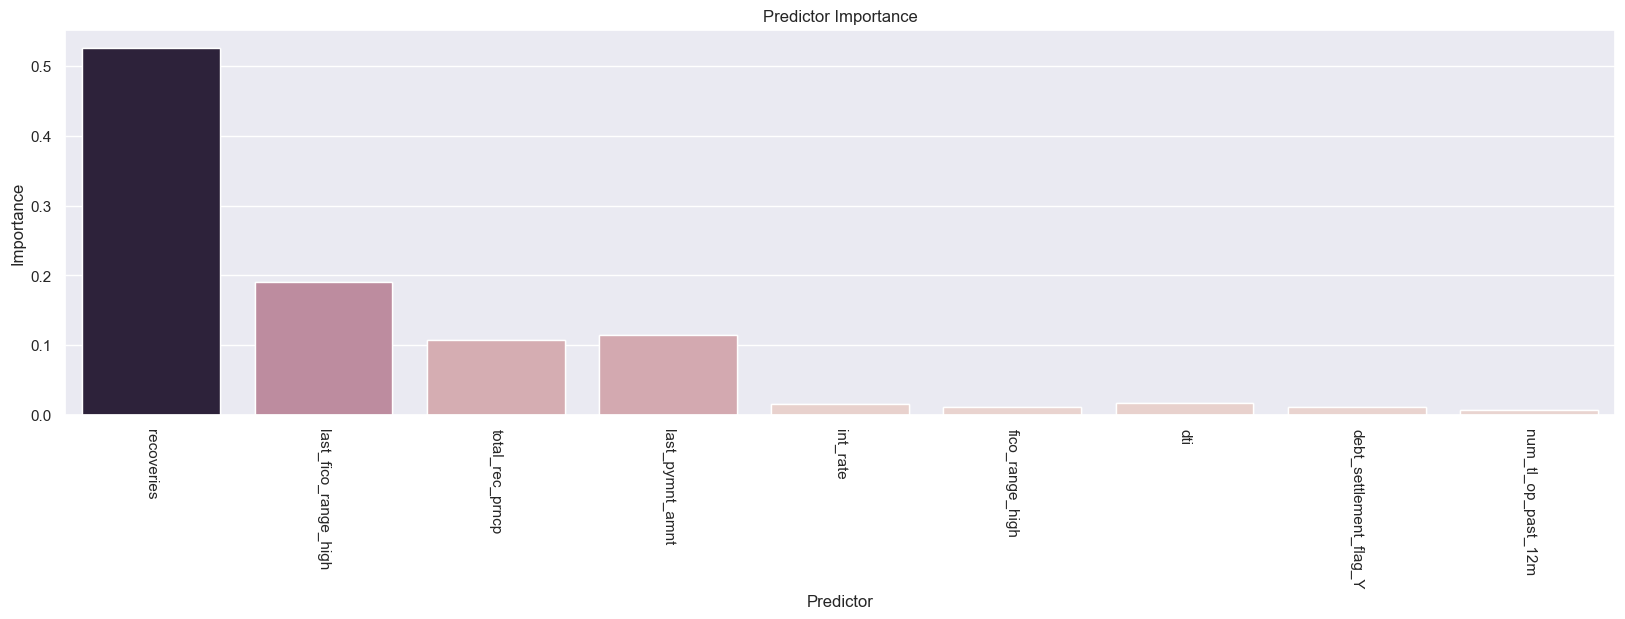

In [54]:
df_random_frst = pd.DataFrame({'Predictor':groups, 'Importance':list(rand_frst.feature_importances_)})
plt.bar(df_random_frst['Predictor'], df_random_frst['Importance'])

ax1 = sns.barplot(df_random_frst, x='Predictor', y='Importance', hue = "Importance", legend = False)
ax1.tick_params(axis='x', labelrotation=-90)
ax1.set_title('Predictor Importance')

In [56]:
# Randon Forest - With fewer predictors
groups_1 = ['recoveries', 'last_fico_range_high',	'total_rec_prncp', 'last_pymnt_amnt','int_rate','dti']
xtr,xts,ytr,yts = train_test_split(data_encoded[groups_1], data_encoded['Bad_Flag'], test_size = 0.25, random_state = 2)

# Initialize the RandomForestClassifier
if len(groups_1) <= 6:
    l = len(groups_1)
else:
    l = int(round(len(groups_1)/2,0)+1)
    
rand_frst = RandomForestClassifier(n_estimators = 400, max_features = l)

# Train the model
rand_frst.fit(xtr, ytr)

# Predict on test set
y_pred = rand_frst.predict(xts)
y_pred_proba = rand_frst.predict_proba(xts)

# Calculate Metrics
test_accuracy = round(accuracy_score(yts,y_pred),4)
logloss = log_loss(yts, y_pred_proba)
print(f'Test Accuracy:{test_accuracy}')
print(f'Log Loss (Cross-Entropy):{logloss}')

Test Accuracy:0.9829
Log Loss (Cross-Entropy):0.0627199204675123


- Here we observe that with the exclusion of 3 additional predictors, the model is remaining stable with change in test loss observed at the order of 10^-3. The predictive power of the model remains unchanged.
- This makes the model more explainable to the business/stake-holders

#### Gradient Boosting Machine

In [58]:
# Gradient Boosting Machine
xtr,xts,ytr,yts = train_test_split(data_encoded[groups], data_encoded['Bad_Flag'], test_size = 0.25, random_state = 2)

# Initialize the GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=400, learning_rate=0.01, max_depth=3, random_state=2)

# Train the model
gb_clf.fit(xtr, ytr)

# Predict on test set
y_pred = gb_clf.predict(xts)
y_pred_proba = gb_clf.predict_proba(xts)

# Calculate Metrics
test_accuracy = round(accuracy_score(yts,y_pred),4)
logloss = log_loss(yts, y_pred_proba)
print(f'Test Accuracy:{test_accuracy}')
print(f'Log Loss (Cross-Entropy):{logloss}')

Test Accuracy:0.9753
Log Loss (Cross-Entropy):0.07316159106628008


### OOT (Out Of Time)

In [60]:
df_accept_subst = df_accept[df_accept['issue_d'].isin(['Jan-2015','Feb-2015','Mar-2015'])]
print(df_accept_subst.shape)

# Creating Bad Flag
df_accept_subst['Bad_Flag'] = [1 if df_accept_subst['loan_status'].iloc[i] == 'Charged Off' else 0 for i in range(len(df_accept_subst))]

#################### Dropping the following variables. These variables donot have significance in predicting the Target #####################
dropped_col = ['loan_status','id','annual_inc','url','title','zip_code','addr_state','issue_d','next_pymnt_d','sub_grade','emp_title',\
               'earliest_cr_line', 'last_credit_pull_d', 'last_pymnt_d', 'hardship_start_date','hardship_end_date','payment_plan_start_date',\
               'debt_settlement_flag_date','settlement_date','desc']

df_accept_subst.drop(dropped_col,axis = 1, inplace = True)
drp_1 = df_accept_subst.shape

# Missing Analyzer - This step tells us the amount of missing values per variable
lst = []
for i in df_accept_subst.columns:
    lst.append((i,round(df_accept_subst[i].isnull().sum()/len(df_accept_subst)*100,8)))

df = pd.DataFrame(lst, columns = ['Var_Name','%Missing']).sort_values(by = '%Missing')

groups = df['Var_Name'].loc[(df['%Missing']>=50) & (df['%Missing']<80) & (~df['Var_Name'].isin(dropped_col))].tolist()

# Obtaining the mean,median,min,max etc. for the variables headed for imputation
df_accept_subst[groups].describe()

################################################## Dropping varibales with Missing % >= 80 ##################################################
for i in df_accept_subst.columns:
    if round(df_accept_subst[i].isnull().sum()/len(df_accept_subst)*100,4) >= 80:
        df_accept_subst.drop(i, axis=1, inplace = True)
drp_2 = df_accept_subst.shape

########################################## Imputing variables where Missing % >= 50 and <80 with 0 ##########################################
groups = df['Var_Name'].loc[(df['%Missing']>=50) & (df['%Missing']<80) & (~df['Var_Name'].isin(dropped_col))].tolist()
df1 = df_accept_subst.copy()
df1 = df1[groups + ['Bad_Flag']]
for i in groups:
    df1[f'{i}_bin'] = (pd.qcut(df1[i], 4)).astype(str)    
    df_temp = df1.groupby(f'{i}_bin').sum()['Bad_Flag']/df1[f'{i}_bin'].value_counts(dropna = False)
    df_temp = df_temp.to_frame().reset_index()
    df_temp.rename(columns={0:'Bad_Rate'}, inplace=True)
    # print(df_temp)

    ''' Since these are delinquency columns, the business might have NULL values for customers who are not delinquent '''
    df_accept_subst[i].loc[df_accept_subst[i].isnull()] = 0
    del df_temp
del df1
drp_3 = df_accept_subst.shape

############################################# Imputing variables where Missing % > 0 and <50 ################################################
''' Binning the columns to be imputed. Imputing with the median value of the non-null bucket, where:
    Bad Rate of Non-Null bucket (is almost) = Bad Rate of Null bucket '''
df1 = df_accept_subst.copy()
groups = df['Var_Name'].loc[(df['%Missing']>0) & (df['%Missing']<50) & (~df['Var_Name'].isin(dropped_col))].tolist()
groups = (df1[groups].select_dtypes(include='number')).columns.tolist()
df1 = df1[groups + ['Bad_Flag']]

for i in groups:
    df1[f'{i}_bin'] = (pd.qcut(df1[i], 4, duplicates='drop')).astype(str)
    df_med = df1.groupby(f"{i}_bin")[i].apply(np.median)
    df_med = df_med.to_frame().reset_index()
    df_med.rename(columns={i: f"{i}_median"}, inplace=True)
    df2 = pd.merge(df1, df_med, on=f'{i}_bin', how = 'inner')
    
    df_temp = df2.groupby(f'{i}_bin').sum()['Bad_Flag']/df2[f'{i}_bin'].value_counts(dropna = False)
    df_temp = df_temp.to_frame().reset_index()
    df_temp.rename(columns={0:'Bad_Rate'}, inplace=True)
    # print(df_temp)
    
    mn = 1000000
    for j in range(len(df_temp)):
        if df_temp[f'{i}_bin'][j] != 'nan':
            val = abs(df_temp['Bad_Rate'][j] - df_temp['Bad_Rate'].loc[df_temp[f'{i}_bin']=='nan'].values[0])
            if val < mn:
                mn = val
                intrvl = df_temp[f'{i}_bin'][j]
    df_accept_subst[i].loc[df_accept_subst[i].isnull()] = df2[f'{i}_median'].loc[df2[f'{i}_bin']==intrvl].unique()[0]
    del df_med, df_temp
del df1, df2

df1 = df_accept_subst.copy()
groups = (df1.select_dtypes(include='number')).columns.tolist()
for i in groups:
    # Calculate quantiles
    lower_limit = df1[i].quantile(0.05)
    upper_limit = df1[i].quantile(0.95)

    # Cap the outliers
    df1[i] = np.where(df1[i] < lower_limit, lower_limit, df1[i])
    df1[i] = np.where(df1[i] > upper_limit, upper_limit, df1[i])

# Applying one-hot encoding
data_encoded = pd.get_dummies(df1, columns=['term','pymnt_plan','purpose','application_type','disbursement_method','debt_settlement_flag'], dtype='int')
data_encoded.shape

dropped_col = data_encoded.select_dtypes(exclude='number').columns.tolist()
data_encoded.drop(dropped_col,axis = 1, inplace = True)

(84277, 151)


In [62]:
groups = ['recoveries', 'last_fico_range_high',	'total_rec_prncp', 'last_pymnt_amnt','int_rate', 'fico_range_high',\
          'dti', 'debt_settlement_flag_Y', 'num_tl_op_past_12m']

In [64]:
# Ridge OOT Test
# Predict on test set
y_pred = best_model.predict(data_encoded[groups])
y_pred_proba = best_model.predict_proba(data_encoded[groups])

# Calculate Metrics
test_accuracy = round(accuracy_score(data_encoded['Bad_Flag'],y_pred),4)
logloss = log_loss(data_encoded['Bad_Flag'], y_pred_proba)
print(f'Test Accuracy:{test_accuracy}')
print(f'Log Loss (Cross-Entropy):{logloss}')

Test Accuracy:0.9641
Log Loss (Cross-Entropy):0.08556710142894697


In [68]:
# GBM OOT Test
# Predict on test set
y_pred = gb_clf.predict(data_encoded[groups])
y_pred_proba = gb_clf.predict_proba(data_encoded[groups])

# Calculate Metrics
test_accuracy = round(accuracy_score(data_encoded['Bad_Flag'], y_pred),4)
logloss = log_loss(data_encoded['Bad_Flag'], y_pred_proba)
print(f'Test Accuracy:{test_accuracy}')
print(f'Log Loss (Cross-Entropy):{logloss}')

Test Accuracy:0.9741
Log Loss (Cross-Entropy):0.07599692128878723


In [66]:
# Random Forest OOT Test
# Predict on test set
y_pred = rand_frst.predict(data_encoded[groups_1])
y_pred_proba = rand_frst.predict_proba(data_encoded[groups_1])

# Calculate Metrics
test_accuracy = round(accuracy_score(data_encoded['Bad_Flag'],y_pred),4)
logloss = log_loss(data_encoded['Bad_Flag'], y_pred_proba)
print(f'Test Accuracy:{test_accuracy}')
print(f'Log Loss (Cross-Entropy):{logloss}')

Test Accuracy:0.9836
Log Loss (Cross-Entropy):0.06180492322965778


### Scorecard Generation

In [121]:
''' 
Since Random Forest proves to be the most accurate algorithm for classifying defaulters vs non-defaulters, we are building the scorecard
based on the probabilities obtained from it.
 Min Score - 300
 Max Score - 850 
'''
df_scr = pd.DataFrame(y_pred_proba)
df_scr['Score'] = [0]*len(df_scr)
for i in range(len(df_scr)):
    df_scr['Score'][i] = 300+(df_scr[0][i]*550)
df_scr['Score'].describe()

count    84277.000000
mean       749.760155
std        201.974891
min        300.000000
25%        836.250000
50%        850.000000
75%        850.000000
max        850.000000
Name: Score, dtype: float64

### Plotting Losses

In [123]:
df_bh = pd.DataFrame({'Algo':['Ridge', 'GBM', 'Random Forest'],\
                      'Train_Error':[0.0822002245989056, 0.07316159106628008, 0.05165800250375114],\
                      'Train_Acc':[0.9662, 0.9753, 0.9841],\
                      'OOT_Error':[0.08556710142894697, 0.07599692128878723, 0.06180492322965778],\
                      'OOT_Acc':[0.9641, 0.9741, 0.9836]})

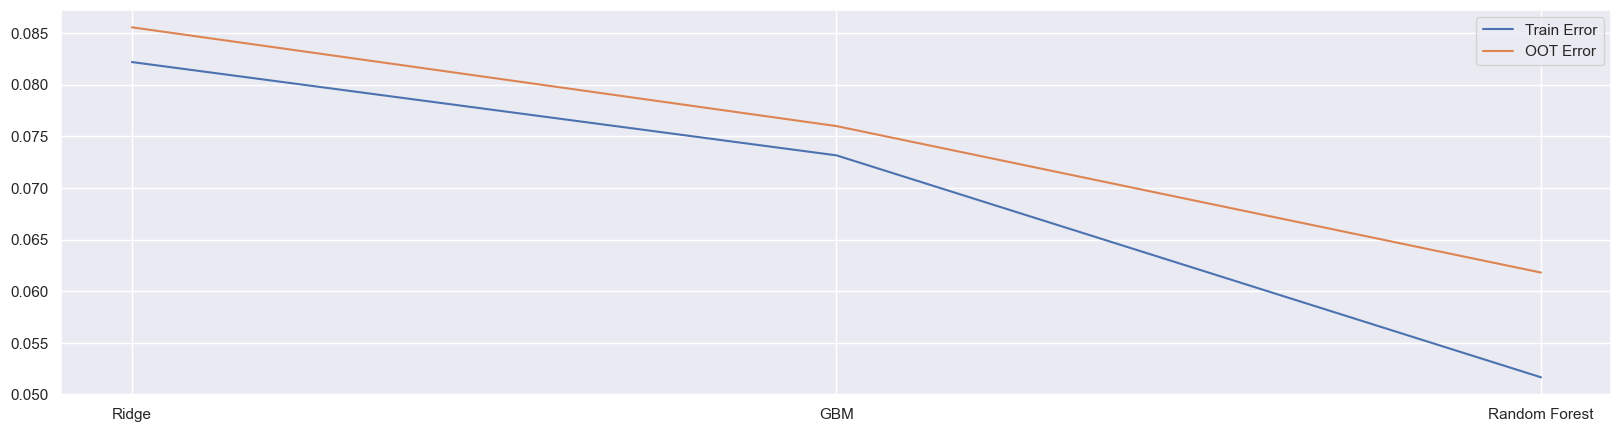

In [125]:
# Plot Errors by Algo
plt.plot(df_bh['Algo'], df_bh['Train_Error'], label = 'Train Error')
plt.plot(df_bh['Algo'], df_bh['OOT_Error'], label = 'OOT Error')
plt.legend()
plt.show()